Enter station number (or 'all' for all stations):  all
Enter equipment number (or 'all' for all equipment):  all


C:\Users\admin\AppData\Local\Temp\ipykernel_6620\915487082.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_footfall = df.resample('H').count()  # Hourly footfall
C:\Users\admin\AppData\Local\Temp\ipykernel_6620\915487082.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_footfall = hourly_footfall.asfreq('H')


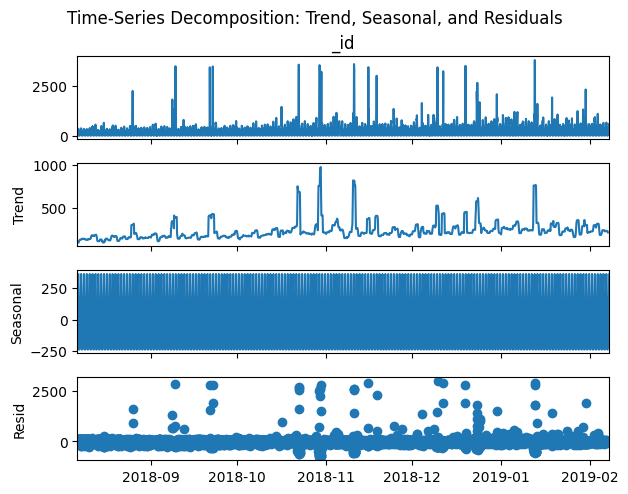

Enter forecast start date (YYYY-MM-DD):  2024-01-01
Enter forecast end date (YYYY-MM-DD):  2024-01-30


16:37:15 - cmdstanpy - INFO - Chain [1] start processing
16:37:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\admin\AppData\Local\Temp\ipykernel_6620\915487082.py:76: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_df = pd.date_range(start=start_date, end=end_date, freq='H')


                   Dt   id  hour
0 2024-01-01 00:00:00  1.0     0
1 2024-01-01 01:00:00 -0.0     1
2 2024-01-01 02:00:00 -1.0     2
3 2024-01-01 03:00:00 -1.0     3
4 2024-01-01 04:00:00 -0.0     4
Files saved to their respective destinations


C:\Users\admin\AppData\Local\Temp\ipykernel_6620\915487082.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_forecast_df['id'] = prophet_forecast_df['id'].round()
C:\Users\admin\AppData\Local\Temp\ipykernel_6620\915487082.py:102: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_forecast_prophet_resampled = daily_forecast_prophet.resample('M').sum()
C:\Users\admin\AppData\Local\Temp\ipykernel_6620\915487082.py:103: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_forecast_prophet_resampled = daily_forecast_prophet.resample('Y').sum()
C:\Users\admin\AppData\Local\Temp\ipykernel_6620\915487082.py:129: SettingWithCopyWarni

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import os
import numpy as np

# Load Dataset
df = pd.read_csv('transaction.csv')  # Replace with your dataset path

# Data Preprocessing
# Correct datetime format to handle '2018-08-06T09:25:42.000Z'
df['Dt'] = pd.to_datetime(df['Dt'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

# Check for any rows where parsing failed
invalid_dates = df[df['Dt'].isnull()]
if not invalid_dates.empty:
    print("Some dates could not be parsed:")
    print(invalid_dates)

# Drop rows with invalid dates if needed
df = df.dropna(subset=['Dt'])

# Continue with setting the index
df.set_index('Dt', inplace=True)

# Filtering based on user input for stn no and EqN
stn_no = input("Enter station number (or 'all' for all stations): ")
eqn_no = input("Enter equipment number (or 'all' for all equipment): ")

# Apply filters
if stn_no.lower() != 'all':
    df = df[df['stn'] == int(stn_no)]
if eqn_no.lower() != 'all':
    df = df[df['EqN'] == int(eqn_no)]

# Aggregating the Footfall at Hourly Level
hourly_footfall = df.resample('H').count()  # Hourly footfall

# Set frequency for hourly_footfall
hourly_footfall = hourly_footfall.asfreq('H')

# Time-Series Decomposition
decomposition = seasonal_decompose(hourly_footfall['_id'], model='additive')
fig = decomposition.plot()
fig.suptitle('Time-Series Decomposition: Trend, Seasonal, and Residuals', y=1.02)
plt.show()

# Specify Forecast Period
start_date = pd.to_datetime(input("Enter forecast start date (YYYY-MM-DD): "))
end_date = pd.to_datetime(input("Enter forecast end date (YYYY-MM-DD): "))
forecast_period = (end_date - start_date).days * 24  # Forecast period in hours

# File Path Base
base_path = r'C:\Users\admin\Desktop\airline\sensor-file-ridership\output of sensors'

# Prophet Model - Alternative Time-Series Forecasting
hourly_footfall_prophet = hourly_footfall.reset_index()

# Ensure the DataFrame only has 'timestamp' and 'transaction_id' after resetting the index
hourly_footfall_prophet = hourly_footfall_prophet[['Dt', '_id']]
hourly_footfall_prophet.columns = ['ds', 'y']  # Rename columns for Prophet

# Convert 'ds' to datetime and 'y' to numeric
hourly_footfall_prophet['ds'] = pd.to_datetime(hourly_footfall_prophet['ds'])
hourly_footfall_prophet['y'] = pd.to_numeric(hourly_footfall_prophet['y'], errors='coerce')

# Apply log transformation (add small constant to avoid log(0) error)
hourly_footfall_prophet['y'] = np.log1p(hourly_footfall_prophet['y'])

# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(hourly_footfall_prophet)

# Create future dataframe starting from the user-specified start_date
future_df = pd.date_range(start=start_date, end=end_date, freq='H')
future_prophet = pd.DataFrame({'ds': future_df})

# Generate predictions
forecast_prophet = prophet_model.predict(future_prophet)

# Inverse the log transformation
forecast_prophet['yhat'] = np.expm1(forecast_prophet['yhat'])

# Creating a DataFrame for Prophet Forecast
prophet_forecast_df = forecast_prophet[['ds', 'yhat']]
prophet_forecast_df.columns = ['Dt', 'id']

# Round off the Prophet forecasted data
prophet_forecast_df['id'] = prophet_forecast_df['id'].round()

# Save Prophet Forecast to CSV
prophet_forecast_df.to_csv(os.path.join(base_path, f'hourly_footfall_forecast_prophet_{stn_no}_{eqn_no}.csv'), index=False)

# Aggregation of Prophet Forecast
daily_forecast_prophet = prophet_forecast_df.copy()
daily_forecast_prophet.set_index('Dt', inplace=True)

# Aggregation: Daily, Weekly, Monthly, Yearly
daily_forecast_prophet_resampled = daily_forecast_prophet.resample('D').sum()
weekly_forecast_prophet_resampled = daily_forecast_prophet.resample('W').sum()
monthly_forecast_prophet_resampled = daily_forecast_prophet.resample('M').sum()
yearly_forecast_prophet_resampled = daily_forecast_prophet.resample('Y').sum()

# Weekend and Weekday Aggregation
weekend_forecast_prophet_resampled = daily_forecast_prophet[daily_forecast_prophet.index.dayofweek >= 5].resample('D').sum()
weekday_forecast_prophet_resampled = daily_forecast_prophet[daily_forecast_prophet.index.dayofweek < 5].resample('D').sum()

# Add week of year and day of week to weekly forecast
weekly_forecast_prophet_resampled['week_of_year'] = weekly_forecast_prophet_resampled.index.isocalendar().week
weekly_forecast_prophet_resampled['day_of_week'] = weekly_forecast_prophet_resampled.index.day_name()

# Add month name to monthly forecast
monthly_forecast_prophet_resampled['month_name'] = monthly_forecast_prophet_resampled.index.month_name()

#all Add day of week to weekend and weekday forecasts
weekend_forecast_prophet_resampled['day_of_week'] = weekend_forecast_prophet_resampled.index.day_name()
weekday_forecast_prophet_resampled['day_of_week'] = weekday_forecast_prophet_resampled.index.day_name()

# Save Aggregated Forecast Data to CSV
daily_forecast_prophet_resampled.to_csv(os.path.join(base_path, f'daily_forecast_prophet_{stn_no}_{eqn_no}.csv'))
weekly_forecast_prophet_resampled.to_csv(os.path.join(base_path, f'weekly_forecast_prophet_{stn_no}_{eqn_no}.csv'))
monthly_forecast_prophet_resampled.to_csv(os.path.join(base_path, f'monthly_forecast_prophet_{stn_no}_{eqn_no}.csv'))
yearly_forecast_prophet_resampled.to_csv(os.path.join(base_path, f'yearly_forecast_prophet_{stn_no}_{eqn_no}.csv'))
weekend_forecast_prophet_resampled.to_csv(os.path.join(base_path, f'weekend_forecast_prophet_{stn_no}_{eqn_no}.csv'))
weekday_forecast_prophet_resampled.to_csv(os.path.join(base_path, f'weekday_forecast_prophet_{stn_no}_{eqn_no}.csv'))

# Aggregation of Prophet Forecast Data by Hour of Day
prophet_forecast_df['hour'] = prophet_forecast_df['Dt'].dt.hour
hourly_aggr_prophet = prophet_forecast_df.groupby('hour')['id'].sum().reset_index()

# Save Aggregated Hourly Prophet Forecast Data to CSV
hourly_aggr_prophet.to_csv(os.path.join(base_path, f'hourly_aggr_prophet_forecast_{stn_no}_{eqn_no}.csv'), index=False)

# Display the Prophet Forecast DataFrame
print(prophet_forecast_df.head())

print("Files saved to their respective destinations")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_raw_data(data_type, file_paths):
    """
    Plots raw data based on the specified data type from the given file paths.
    Additionally plots weekday vs. weekend data if 'weekday_vs_weekend' is specified.
    
    Parameters:
    - data_type (str): Type of data to plot ('daily', 'weekly', 'monthly', 'yearly', 'weekend', 'weekday', 'weekday_vs_weekend', 'hourly').
    - file_paths (dict): Dictionary containing file paths for each data type.
    """
    if data_type == 'weekday_vs_weekend':
        # Load Weekend Dataset
        weekend_file_path = file_paths['weekend']
        weekend_df = pd.read_csv(weekend_file_path)
        weekend_df['Dt'] = pd.to_datetime(weekend_df['Dt'])
        weekend_df.set_index('Dt', inplace=True)
        
        # Load Weekday Dataset
        weekday_file_path = file_paths['weekday']
        weekday_df = pd.read_csv(weekday_file_path)
        weekday_df['Dt'] = pd.to_datetime(weekday_df['Dt'])
        weekday_df.set_index('Dt', inplace=True)
        
        # Print the raw data to check its structure
        print("Raw weekend data:")
        print(weekend_df.head())
        print("Raw weekday data:")
        print(weekday_df.head())
        
        # Plotting Weekday vs Weekend Footfall Over Time
        plt.figure(figsize=(12, 6))
        plt.plot(weekend_df.index, weekend_df['id'], label='Weekend Footfall', color='purple')
        plt.plot(weekday_df.index, weekday_df['id'], label='Weekday Footfall', color='cyan')
        plt.title('Weekday vs Weekend Footfall Over Time')
        plt.xlabel('dt')
        plt.ylabel('IDs')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Aggregating total transactions for weekday vs weekend
        total_weekend = weekend_df['id'].sum()
        total_weekday = weekday_df['id'].sum()
        
        # Creating a DataFrame for aggregation
        aggregated_df = pd.DataFrame({
            'Footfall Type': ['Weekday', 'Weekend'],
            'Total Transactions IDs': [total_weekday, total_weekend]
        })
        
        # Plotting Aggregated Weekday vs Weekend Data
        plt.figure(figsize=(8, 6))
        plt.bar(aggregated_df['Footfall Type'], aggregated_df['Total Transactions IDs'], color=['cyan', 'purple'])
        plt.title('Total Weekday vs Weekend Footfall')
        plt.xlabel('Footfall Type')
        plt.ylabel('Total IDs')
        plt.grid(True)
        plt.show()

    elif data_type == 'monthly':
        # Load Daily Dataset
        daily_file_path = file_paths['daily']
        daily_df = pd.read_csv(daily_file_path)
        daily_df['Dt'] = pd.to_datetime(daily_df['Dt'])
        daily_df.set_index('Dt', inplace=True)
        
        # Aggregate Data to Monthly Totals
        monthly_footfall = daily_df.resample('M').sum()  # Aggregating daily data into monthly totals
        monthly_footfall['month_name'] = monthly_footfall.index.month_name()
        monthly_footfall['year'] = monthly_footfall.index.year
        
        # Print the aggregated data
        print("Monthly Aggregated Data:")
        print(monthly_footfall.head())
        
        # Optionally, save the aggregated data to a new CSV file
        aggregated_file_path = os.path.join(base_path, f'monthly_aggregated_data_{stn_no}_{eqn_no}.csv')
        monthly_footfall.to_csv(aggregated_file_path)
        print(f"Aggregated data saved to {aggregated_file_path}")
        
        # Plotting the aggregated monthly data
        plt.figure(figsize=(12, 6))
        monthly_footfall.plot(y='id', kind='bar', color='orange', legend=False)
        plt.title('Monthly Footfall Aggregated from Daily Data')
        plt.xlabel('Month')
        plt.ylabel('IDs')
        plt.xticks(ticks=range(len(monthly_footfall)), labels=monthly_footfall['month_name'], rotation=45)
        plt.grid(True)
        plt.show()

    elif data_type == 'yearly':
        # Load Yearly Dataset
        yearly_file_path = file_paths['yearly']
        yearly_df = pd.read_csv(yearly_file_path)
        yearly_df['Dt'] = pd.to_datetime(yearly_df['Dt'])
        yearly_df.set_index('Dt', inplace=True)
        yearly_df['year'] = yearly_df.index.year
        
        # Print the raw data to check its structure
        print("Raw yearly data:")
        print(yearly_df.head())
        
        # Plotting the yearly data
        plt.figure(figsize=(12, 6))
        yearly_df.groupby('year').sum().plot(y='id', kind='bar', color='blue', legend=False)
        plt.title('Yearly Footfall')
        plt.xlabel('Year')
        plt.ylabel('IDs')
        plt.grid(True)
        plt.show()

    elif data_type == 'weekly':
        # Load Weekly Dataset
        weekly_file_path = file_paths['weekly']
        weekly_df = pd.read_csv(weekly_file_path)
        weekly_df['Dt'] = pd.to_datetime(weekly_df['Dt'])
        weekly_df.set_index('Dt', inplace=True)
        
        # Compute Week of Month
        weekly_df['week_of_month'] = weekly_df.index.to_series().apply(lambda x: (x.day - 1) // 7 + 1)
        
        # Filter to show only the first 4 weeks of the month
        weekly_df = weekly_df[weekly_df['week_of_month'] <= 4]
        
        # Print the raw data to check its structure
        print("Raw weekly data:")
        print(weekly_df.head())
        
        # Plotting the weekly data
        plt.figure(figsize=(12, 6))
        weekly_df.groupby('week_of_month').sum().plot(y='id', kind='bar', color='blue', legend=False)
        plt.title('Weekly Footfall Aggregated by Week of Month (First 4 Weeks)')
        plt.xlabel('Week of Month')
        plt.ylabel('IDs')
        plt.grid(True)
        plt.show()
    
    elif data_type == 'weekend':
        # Load Weekend Dataset
        weekend_file_path = file_paths['weekend']
        weekend_df = pd.read_csv(weekend_file_path)
        weekend_df['Dt'] = pd.to_datetime(weekend_df['Dt'])
        weekend_df.set_index('Dt', inplace=True)
        weekend_df['day_of_week'] = weekend_df.index.day_name()
        
        # Print the raw data to check its structure
        print("Raw weekend data:")
        print(weekend_df.head())
        
        # Plotting the weekend data
        plt.figure(figsize=(12, 6))
        weekend_df.groupby('day_of_week').sum().plot(y='id', kind='bar', color='green', legend=False)
        plt.title('Weekend Footfall Aggregated by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('IDs')
        plt.grid(True)
        plt.show()
    
    elif data_type == 'weekday':
        # Load Weekday Dataset
        weekday_file_path = file_paths['weekday']
        weekday_df = pd.read_csv(weekday_file_path)
        weekday_df['Dt'] = pd.to_datetime(weekday_df['Dt'])
        weekday_df.set_index('Dt', inplace=True)
        weekday_df['day_of_week'] = weekday_df.index.day_name()
        
        # Print the raw data to check its structure
        print("Raw weekday data:")
        print(weekday_df.head())
        
        # Plotting the weekday data
        plt.figure(figsize=(12, 6))
        weekday_df.groupby('day_of_week').sum().plot(y='id', kind='bar', color='red', legend=False)
        plt.title('Weekday Footfall Aggregated by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('IDs')
        plt.grid(True)
        plt.show()

    elif data_type == 'hourly':
        # Load Hourly Aggregated Forecast Dataset
        hourly_file_path = file_paths['hourly']
        hourly_df = pd.read_csv(hourly_file_path)
        '''hourly_df['hour'] = pd.to_datetime(hourly_df['hour'])
        hourly_df.set_index('hour', inplace=True)'''
        
        # Print the raw data to check its structure
        print("Raw hourly aggregated forecast data:")
        print(hourly_df.head())
    
        # Plotting the hourly aggregated forecast data
        plt.figure(figsize=(12, 6))
        plt.plot(hourly_df.index, hourly_df['id'], label='Hourly Footfall Forecast', color='orange')
        plt.title('Hourly Aggregated Forecast Footfall')
        plt.xlabel('Hour')
        plt.ylabel('IDs')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    else:
        # Load Dataset
        file_path = file_paths.get(data_type)
        if file_path:
            df = pd.read_csv(file_path)
            
            # Data Preprocessing
            df['Dt'] = pd.to_datetime(df['Dt'])
            df.set_index('Dt', inplace=True)
            
            # Print the raw data to check its structure
            print(f"Raw data for {data_type}:")
            print(df.head())

            # Plotting the raw data
            plt.figure(figsize=(12, 6))
            plt.plot(df.index, df['id'], label=f'Raw {data_type.capitalize()} Footfall', color='blue')
            plt.title(f'Raw {data_type.capitalize()} Footfall Over Time')
            plt.xlabel('Dt')
            plt.ylabel('IDs')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"File path for '{data_type}' data type is not provided.")

def main():
    # Define the base path for output files
    base_path = r'C:\Users\admin\Desktop\airline\sensor-file-ridership\output of sensors'
    
    # Get station number and equation number from the user
    stn_no = input("Enter the station number (stn_no): ").strip()
    eqn_no = input("Enter the equation number (eqn_no): ").strip()
    
    # Define file paths for different forecast types
    file_paths = {
        'daily': os.path.join(base_path, f'daily_forecast_prophet_{stn_no}_{eqn_no}.csv'),
        'weekly': os.path.join(base_path, f'weekly_forecast_prophet_{stn_no}_{eqn_no}.csv'),
        'monthly': os.path.join(base_path, f'monthly_forecast_prophet_{stn_no}_{eqn_no}.csv'),
        'yearly': os.path.join(base_path, f'yearly_forecast_prophet_{stn_no}_{eqn_no}.csv'),
        'weekend': os.path.join(base_path, f'weekend_forecast_prophet_{stn_no}_{eqn_no}.csv'),
        'weekday': os.path.join(base_path, f'weekday_forecast_prophet_{stn_no}_{eqn_no}.csv'),
        'hourly': os.path.join(base_path, f'hourly_aggr_prophet_forecast_{stn_no}_{eqn_no}.csv')  # Path for hourly aggregated forecast
    }

    # Get user input for data type
    data_type = input("Enter the data type to plot ('daily', 'weekly', 'monthly', 'yearly', 'weekday_vs_weekend', 'weekend', 'weekday', 'hourly'): ").strip().lower()

    # Plot the data based on user input
    plot_raw_data(data_type, file_paths)

if __name__ == "__main__":
    main()